In [1]:
import numpy as np
from scipy.optimize import minimize
from desdeo_problem import variable_builder, ScalarObjective, MOProblem
from desdeo_problem.testproblems.TestProblems import test_problem_builder
import plotly.graph_objects as go
from desdeo_mcdm.utilities.solvers import solve_pareto_front_representation
from desdeo_mcdm.interactive.ReferencePointMethod import ReferencePointMethod
import matplotlib.pyplot as plt

In [2]:
# Define objective functions
def f1(x):
    return x**2

def f2(x):
    return (x-2)**2

def compute_multipliers(objectives, num_variables, lower_bounds, upper_bounds, w, z_dot):
    # Initial guess for alpha and variables
    initial_guess = np.zeros(num_variables+1)
    num_objectives = len(objectives)
    
    # Define the bounds for alpha
    bounds = ((0, None),)  # No bounds for alpha

    for i in range(num_variables):
        bounds += ((lower_bounds[i], upper_bounds[i]),)
    
    constraints = []
    for i in range(num_objectives):
        # Define the constraint equation using the current indices
        constraint_eq = lambda x, i=i: w[i] * (objectives[i](x[1]) - z_dot[i]) - x[0]
    
        # Define the constraint using the lambda function
        constraint = {'type': 'ineq', 'fun': constraint_eq}
    
        # Append the constraint to the constraints list
        constraints.append(constraint)
    
    
    # Minimize alpha subject to the constraints
    result = minimize(lambda x: -x[0], initial_guess, bounds=bounds, constraints=constraints, method='trust-constr')
    
    # Calculate Lagrange multipliers
    lagrange_multipliers = np.array([item for sublist in result.v for item in sublist])
    lagrange_multipliers[0:num_objectives] *= -1
    return result.x, lagrange_multipliers[0:num_objectives]


In [3]:
def compute_approximate_pareto_optimal_objective_vector(dot_z, lambdas, d, weights):
    """
    Compute the approximate Pareto optimal objective vector.

    Args:
    dot_z (numpy.ndarray): Current objective vector.
    d (numpy.ndarray): Direction vector.
    n (numpy.ndarray): Normal vector.
    w_inv (numpy.ndarray): Inverse of the weight vector.

    Returns:
    numpy.ndarray: Approximate Pareto optimal objective vector.
    """
    k = len(dot_z)  # Number of objectives
    w_inv = 1 / np.array(weights)
    n = -np.array([lambdas[i] * weights[i] for i in range(k)])
    dot_z = np.array(dot_z)
    d = np.array(d)
    n = np.array(n)
    w_inv = np.array(w_inv)
    t = -np.dot(n.T, d) / np.dot(n.T, w_inv)
    approximate_z = dot_z + d + t * w_inv
    return approximate_z

C:\Users\Giomara\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


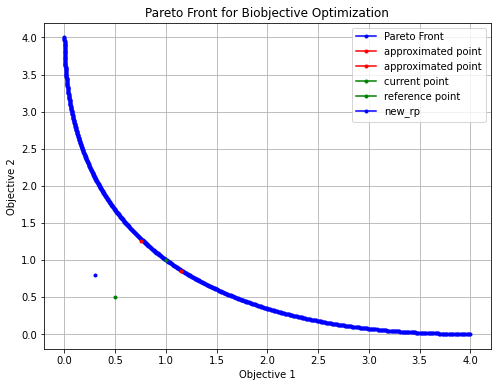

[0.50141612 0.50180444]


In [4]:
# Main function to compute and plot Pareto front
def plot(w, z_i, z_dot, d, approximate_z, approximate_z2):
    # Decision variable range
    x = np.linspace(0, 3, 1000)
    
    # Compute objective values
    y1 = f1(x)
    y2 = f2(x)
    
    # Find non-dominated solutions
    pareto_front = []
    for i in range(len(x)):
        dominated = False
        for j in range(len(x)):
            if i != j:
                if y1[j] <= y1[i] and y2[j] <= y2[i]:
                    dominated = True
                    break
        if not dominated:
            pareto_front.append((y1[i], y2[i]))
    
    pareto_front = np.array(pareto_front)
    
    # Plot Pareto front
    plt.figure(figsize=(8, 6))
    plt.plot(pareto_front[:, 0], pareto_front[:, 1], label='Pareto Front', color='blue', marker='.')
    plt.plot(approximate_z[0], approximate_z[1], label='approximated point', color='red', marker='.')
    plt.plot(approximate_z2[0], approximate_z2[1], label='approximated point', color='red', marker='.')
    plt.plot(z_i[0], z_i[1], label='current point', color='green', marker='.')
    plt.plot(z_dot[0], z_dot[1], label='reference point', color='green', marker='.')
    plt.plot(z_dot[0] + d[0], z_dot[1] + d[1], label='new_rp', color='blue', marker='.')
    plt.xlabel('Objective 1')
    plt.ylabel('Objective 2')
    plt.title('Pareto Front for Biobjective Optimization')
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    num_variables = 1
    lower_bounds = [0]
    upper_bounds = [3]
    w = [0.5,0.5]   
    z_dot = [0.5,0.5]
    d = [-0.2, 0.3]
    d2 = [0.2,-0.1]

    objectives = [f1,f2]
    x, lagrange_multipliers = compute_multipliers(objectives, num_variables, lower_bounds, upper_bounds, w, z_dot)
    fx = [f1(x[1]), f2(x[1])]
    approximate_z = compute_approximate_pareto_optimal_objective_vector(fx,lagrange_multipliers, d, w)
    approximate_z2 = compute_approximate_pareto_optimal_objective_vector(fx,lagrange_multipliers, d2, w)
    plot(w, fx, z_dot, d, approximate_z, approximate_z2)

    print(lagrange_multipliers)